In [1]:

# File Settings
ROOT_FOLDERS = ['/kaggle/input/spanish-single-speaker-speech-dataset/', '/kaggle/input/120h-spanish-speech/asr-spanish-v1-carlfm01/']
CSV_FILE_PATH_1 = ROOT_FOLDERS[0] + 'transcript.txt'
CSV_FILE_PATH_2 = ROOT_FOLDERS[1] + 'files.csv'
CSV_FILE_PATH = [CSV_FILE_PATH_1, CSV_FILE_PATH_2]

SAVE_RESULTS_PATH = '/kaggle/working/'
SAVE_MODELS_PATH = '/kaggle/working/'

  

In [2]:
# Systems Libraries
import os
import time

# For audio processing
import librosa
import librosa.display
import IPython as ipd

#from torchsummary import summary

# For data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For Neural networks
import torch
from torch import nn
import pickle as pkl
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# For visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



# For text processing
import string

# Scripts created by me:
import utils
import models
import textprocessor
import speechdataset

from datetime import datetime



from random import choice
import random
import math

import soundfile as sf


# Audio Sample
Hear one of the audios.

In [3]:
ipd.display.Audio(filename='../input/spanish-single-speaker-speech-dataset/batalla_arapiles/batalla_arapiles_0010.wav')

# Plot audio

Plot the audio in different formats:

* Waveform
* Spectrogram.

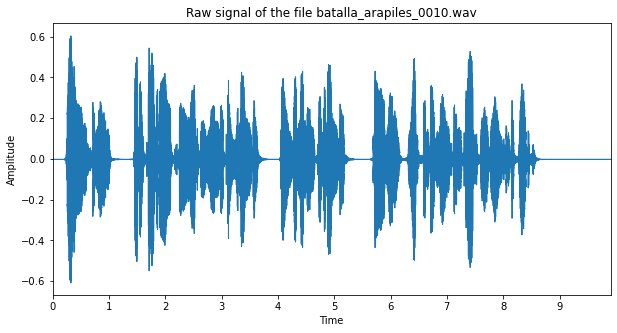

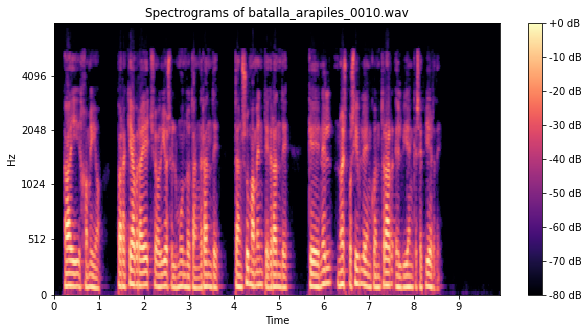

In [4]:
(waveform, sample_rate) = librosa.load('../input/spanish-single-speaker-speech-dataset/batalla_arapiles/batalla_arapiles_0010.wav')
spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
utils.plot_all(audio_data=waveform, spec=spectrogram, sr=sample_rate, file='batalla_arapiles_0010.wav')

# Data Pre-processing:

Before starting to analyse the data, let's do some clean up. The path which looks like 19demarzo/19marzo_XXXX.wav will be split into two other columns and thus we will have a table like this:


| index | path    |	utterance  | label   | duration	 | dir	   | file    |
|------ |---------|------------|---------|-----------|---------|---------|
|0	| 19demarzo/19demarzo_0000.wav	| Durante nuestra conversación advertí que la mu...|	Durante nuestra conversación advertí que la mu...|	5.88	| 19demarzo	|19demarzo_0000.wav |
|1|	19demarzo/19demarzo_0001.wav|	Componíanla personas de ambos sexos y de todas...|	Componíanla personas de ambos sexos y de todas...|	4.52|	19demarzo	|19demarzo_0001.wav |
|2|	19demarzo/19demarzo_0002.wav|	espontáneamente venidas por uno de esos llamam...|	espontáneamente venidas por uno de esos llamam...|	8.31|	19demarzo |	19demarzo_0002.wav |
|3|	19demarzo/19demarzo_0003.wav|	y resuenan de improviso en los oídos de un pue...|	y resuenan de improviso en los oídos de un pue...|	7.20|	19demarzo |	19demarzo_0003.wav |
|4|	19demarzo/19demarzo_0004.wav|	La campana de ese arrebato glorioso no suena s...|	La campana de ese arrebato glorioso no suena s...|	7.50|	19demarzo |	19demarzo_0004.wav |





## Clearing up unnecessary data

It is clear that there are accents, commas, etc. that we don't really care about. So, let's clear those up.
We will also clearup the data where the utterance is empty with the command d.dropna.


# Processing the audio data.
For the audio, I need to get the spectrogram or mfccs and the utterance (as the label).
The custom dataset saved as a utility script as speechdataset was created following the Custom Dataset tutorial by pytorch:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**The utility script can be found named as speechdataset.**

In [5]:
def load_dataset(csv_files, root_dir):
  
  # Create the dataset and split into validation dataset and test dataset.
    total_dataset = speechdataset.SpanishSpeechDataSet(csv_files=csv_files, root_dir=root_dir)
    train_size = int(0.8 * len(total_dataset))
    val_test_size = len(total_dataset) - train_size
    train_dataset, val_test_dataset = torch.utils.data.random_split(total_dataset, [train_size, val_test_size])
    valid_size = int(0.9 * len(val_test_dataset))
    test_size = len(val_test_dataset) - valid_size
    val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [valid_size, test_size])
    print("Total Training Dataset = {}, Valid Dataset = {} and Test Dataset = {}".format(len(train_dataset),len(val_dataset), len(test_dataset) ))
    print("Total --> ", len(train_dataset)+len(val_dataset)+len(test_dataset))
    sample = train_dataset[0]
    print("*****Showing spectorgram with label:**** \n")
    print(sample[1])
    utils.plot_spec(sample[0], title="Mel spectrogram")
    return (train_dataset, val_dataset, test_dataset)




### Pad the data
As the audio files have different lengths. We need to pad the data and create batches. 

For example if the batch size = 3
 spec1 = [1 2 3 4 5]
 spec2 = [6 7 8]
 spec3 = [9 3]
data_processing function will create batches like:

1 batch:
* [1 2 3 4 5]
* [6 7 8 0 0]
* [9 3 0 0 0]

In [6]:

# The following code will be for collat_fn for the pytorch dataloader function    
def data_processing(audio_data):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    #print("data processing")
    for (spec,label) in audio_data:
        #The spectrogram is in (128, 407) and (128, 355) for example but later on for padding the function expects (407, 128) and (355, 128). So we need to transpose the matrices.
        spectrograms.append(torch.Tensor(spec.transpose()))
        t = textprocessor.TextProcessor()
        label = torch.Tensor(t.text2int(text=label))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))
    #print("Start padding")
    spec_pad = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2,3)   #(batch, channel=1, features, time )
    label_pad = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    #print("Finish padding")
    return spec_pad, label_pad, input_lengths, label_lengths



### Create data loader

In [7]:

def create_data_loaders(train_dataset, val_dataset, test_dataset, kwargs, batch_size):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs )
    valid_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs)
    return (train_loader, valid_loader, test_loader)

### Training function

Ready for training and validating. Using earling stopping using the library from --> https://github.com/Bjarten/early-stopping-pytorch/

We will set up the patience to 15


In [8]:

def train(n_epochs, train_loader, valid_loader, model, criterion, clip, device, lr, batch_size, save_model_path, save_pkl_path, model_name, show_every_n_batch=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=n_epochs,
                                            anneal_strategy='linear')
    train_data_len = len(train_loader.dataset)
    valid_data_len = len(valid_loader.dataset)
    epoch_train_loss = 0
    epoch_val_loss = 0
    train_losses = []
    valid_losses = []
    print("#######################")
    print("#  Start Training    #")
    print("#######################")
    
    model.train()
    for e in range(n_epochs):
        t0 = time.time()
        #Initialize hidden state
        h = model.init_hidden(batch_size, device)

        #batch loop
        running_loss = 0.0
        for batch_idx, _data in enumerate(train_loader, 1):
            specs, labels, input_lengths, label_lengths = _data
            specs, labels = specs.to(device), labels.to(device)
            #print(batch_idx)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = h.detach()
            # zero accumulated gradients
            model.zero_grad()
            # get the output from the model
            output, h = model(specs, h)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0,1)
            # calculate the loss and perform backprop
            loss = criterion(output, labels.float(), input_lengths, label_lengths)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            scheduler.step()
            # loss stats
            running_loss += loss.item() * specs.size(0)
            if (batch_idx % 1000 == 0):
                output = output.transpose(1,0)
                #print("Training Batch Number: ", batch_idx)
                (decoded_preds, decoded_targets) = textprocessor.GreedyDecoder(output, labels, label_lengths)
                for j in range(len(decoded_preds)):
                    #print("****************************************************************************")
                    #print("Predicted -- {}".format(decoded_preds[j]))
                    #print("Utterance -- {}\n\n".format(decoded_targets[j]))
                    utils.write_to_csv('/kaggle/working/'+model_name+'_training_results.csv', decoded_preds[j], decoded_targets[j], running_loss, epoch=e+1)
                
        t_t = time.time() - t0

            
        ######################    
        # validate the model #
        ######################
        with torch.no_grad():
            model.eval() 
            tv = time.time()
            running_val_loss = 0.0
            for batch_idx_v, _data in enumerate(valid_loader, 1):
                specs, labels, input_lengths, label_lengths = _data
                specs, labels = specs.to(device), labels.to(device)
                val_h = model.init_hidden(batch_size, device)
                output, val_h = model(specs, val_h)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0,1)
                val_loss = criterion(output, labels.float(), input_lengths, label_lengths)
                running_val_loss += val_loss.item() * specs.size(0)
                if (batch_idx_v % 200 == 0):
                    output = output.transpose(1,0)
                    #print("Validation Batch Number: ", batch_idx)
                    (decoded_preds, decoded_targets) = textprocessor.GreedyDecoder(output, labels, label_lengths)
                    for j in range(len(decoded_preds)):
                        #print("****************************************************************************")
                        #print("Predicted -- {}".format(decoded_preds[j]))
                        #print("Utterance -- {}\n\n".format(decoded_targets[j]))
                        utils.write_to_csv('/kaggle/working/'+model_name+'_validation_results.csv', decoded_preds[j], decoded_targets[j], running_val_loss, epoch=e+1)
            print("Epoch {}: Training took {:.2f} [s]\tValidation took: {:.2f} [s]\n".format(e+1, t_t, time.time() - tv))
                
                
        epoch_train_loss = running_loss / train_data_len
        epoch_val_loss = running_val_loss / valid_data_len
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_val_loss)
        print('Epoch: {} Losses\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
                e+1, epoch_train_loss, epoch_val_loss))
        model.train()
        
        print("-------------------------------------------------------------------------------------------")
        print('Epoch {} took total {} seconds'.format(e+1, time.time() - t0))
        print("-------------------------------------------------------------------------------------------")

    with open(save_pkl_path, 'wb') as f:       #this will save the list as "results.pkl" which you can load in later 
        pkl.dump((epoch_train_loss, epoch_val_loss), f)
    utils.save_model(save_path=save_model_path, model=model)
    utils.save_checkpoint(save_path=save_model_path, model=model, optimizer=optimizer, epoch=e, loss=train_losses)
    return (model, train_losses, valid_losses)

### Test Model

Calculation of WER and CER is done using the code from deepspeech. The average WER and CER is displayed at the end of the test.
Greedydecoder is used to decode the predicted char.

In [9]:
def test_model(test_data, model, model_name,device, batch_size):
    model.eval()
    print("#######################")
    print("# Testing Model: {} #".format(model_name))
    print("#######################\n\n")
    test_cer, test_wer = [], []
    test_loss = 0.0
    h = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for batch_idx, _data in enumerate(test_data, 1):
            specs, labels, input_lengths, label_lengths = _data
            specs, labels = specs.to(device), labels.to(device)
            # initialize the hidden state
            # get the output of the rnn
            output, _ = model(specs, h)    
            output = output.transpose(0,1) #(time, batch,n_class)
            loss = criterion(output, labels, input_lengths, label_lengths)
            #Input should be [batch, time, n_classes]
            output = output.transpose(1,0)
            (decoded_preds, decoded_targets) = textprocessor.GreedyDecoder(output, labels, label_lengths)
            test_loss += loss.item()* specs.size(0)
            #print(test_loss.item())
            for j in range(len(decoded_preds)):
                print("****************************************************************************")
                print("Predicted -- {}".format(decoded_preds[j]))
                print("Utterance -- {}\n\n".format(decoded_targets[j]))
                test_cer.append(textprocessor.cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(textprocessor.wer(decoded_targets[j], decoded_preds[j]))
                utils.write_to_csv('/kaggle/working/'+model_name + '_testing_results.csv', decoded_preds[j], decoded_targets[j], test_loss)
    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    print('Test set:Average CER: {:4f} Average WER: {:.4f}\n'.format(avg_cer, avg_wer))                           
    

    

In [10]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
input_size = 128
n_classes = 29
hidden_dim = 512
n_layers = 1
clip=5 # gradient clipping

lr = 5e-4
epochs = 25
batch_size=32
n_gru_layers=4

criterion = nn.CTCLoss(blank=28, zero_infinity=True)

# Load the data

Total Training Dataset = 15858, Valid Dataset = 3568 and Test Dataset = 397
Total -->  19823
*****Showing spectorgram with label:**** 

pero esta de que me ocupo es peligrosa y tan dificil que es indispensable ocultar por completo mi persona


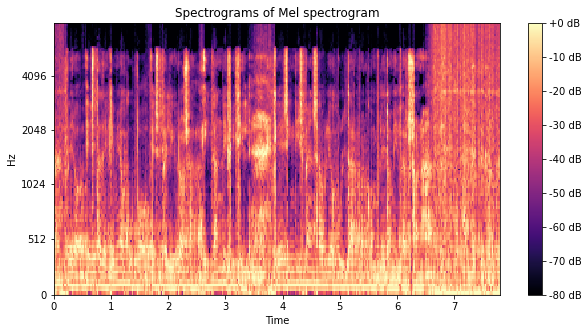

In [12]:

kwargs={'num_workers': 4, 'pin_memory': True} if use_cuda else {}
(train_dataset, val_dataset, test_dataset) = load_dataset(csv_files=CSV_FILE_PATH, root_dir=ROOT_FOLDERS)
(train_loader, valid_loader, test_loader) = create_data_loaders(train_dataset, val_dataset, test_dataset, kwargs=kwargs, batch_size=batch_size)
    

In [13]:
gru_net = models.OnlyRNN(input_size=input_size, n_classes=n_classes, hidden_dim=hidden_dim, n_layers=n_layers,
                         n_gru_layers=n_gru_layers, drop_prob=0.2, apply_layer_norm=False, bidir=False)
gru_net.apply(models.weight_init)
gru_net.to(device)

OnlyRNN(
  (gru_layers): Sequential(
    (0): GRULayer(
      (GRULayer): GRU(128, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): GRULayer(
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): GRULayer(
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): GRULayer(
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (classifier): Linear(in_features=512, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
print(models.count_parameters(gru_net))

5728797


# Start training 1st model

In [15]:
model_name="Only-GRU"
(gru_trained_model, gru_train_losses, gru_valid_losses) = train(n_epochs=epochs, train_loader=train_loader,
                                                                 valid_loader=valid_loader,
                                                                 model=gru_net, criterion=criterion, clip=clip,
                                                                 device=device, lr=lr, batch_size=batch_size,
                                                                 model_name=model_name,
                                                                 save_model_path=SAVE_RESULTS_PATH+model_name,
                                                                 save_pkl_path=SAVE_MODELS_PATH + "training_"+model_name+".pkl")


#######################
#  Start Training    #
#######################
Epoch 1: Training took 141.98 [s]	Validation took: 23.96 [s]

Epoch: 1 Losses	Training Loss: 1.051690	Validation Loss: 0.985688
-------------------------------------------------------------------------------------------
Epoch 1 took total 165.93954467773438 seconds
-------------------------------------------------------------------------------------------
Epoch 2: Training took 136.81 [s]	Validation took: 22.66 [s]

Epoch: 2 Losses	Training Loss: 1.030663	Validation Loss: 0.985861
-------------------------------------------------------------------------------------------
Epoch 2 took total 159.47292041778564 seconds
-------------------------------------------------------------------------------------------
Epoch 3: Training took 136.85 [s]	Validation took: 21.14 [s]

Epoch: 3 Losses	Training Loss: 1.028362	Validation Loss: 1.001944
-------------------------------------------------------------------------------------

# Test 1st model

In [16]:
test_model(test_loader, gru_trained_model, model_name, device, batch_size=batch_size)

#######################
# Testing Model: Only-GRU #
#######################


****************************************************************************
Predicted -- a ai
Utterance -- al recoger de mis manos la bandera el general despuesde preguntarme si era licenciado de presidio me dijo es vd sargento


****************************************************************************
Predicted -- ye e e e e a e e a e a a a a e a a a aea
Utterance -- nosotros apreciamos a este mala cabeza de santorcaz


****************************************************************************
Predicted -- ye e e e a e a a e e a e a e a a a e eea
Utterance -- imposibilitando de un modo absoluto la realizacion de mi proyecto


****************************************************************************
Predicted -- ye e e e a e e e e a a a a e a eio
Utterance -- dijo que yendo de camino se habia extraviado no sabia donde estaba y buscaba albergue en que pasar la noche


*********************************

In [17]:
gru_layer_net = models.OnlyRNN(input_size=input_size, n_classes=n_classes, hidden_dim=hidden_dim, n_layers=n_layers,
                         n_gru_layers=n_gru_layers, drop_prob=0.2, apply_layer_norm=True, bidir=False)
gru_layer_net.apply(models.weight_init)
gru_layer_net.to(device)

OnlyRNN(
  (gru_layers): Sequential(
    (0): GRULayer(
      (GRULayer): GRU(128, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): GRULayer(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): GRULayer(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): GRULayer(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(512, 512, batch_first=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (classifier): Linear(in_features=512, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
print(models.count_parameters(gru_layer_net))

5731869


# Train 2nd model

In [19]:
model_name="Only-GRU-Layer"
(gru_layer_trained_model, gru_layer_train_losses, gru_layer_valid_losses) = train(n_epochs=epochs, train_loader=train_loader,
                                                                     valid_loader=valid_loader,
                                                                     model=gru_layer_net, criterion=criterion, clip=clip,
                                                                     device=device, lr=lr, batch_size=batch_size,
                                                                     model_name=model_name,
                                                                     save_model_path=SAVE_RESULTS_PATH+model_name,
                                                                     save_pkl_path=SAVE_MODELS_PATH + "training_"+model_name+".pkl")


#######################
#  Start Training    #
#######################
Epoch 1: Training took 141.11 [s]	Validation took: 23.17 [s]

Epoch: 1 Losses	Training Loss: 1.090350	Validation Loss: 0.988210
-------------------------------------------------------------------------------------------
Epoch 1 took total 164.28215718269348 seconds
-------------------------------------------------------------------------------------------
Epoch 2: Training took 141.29 [s]	Validation took: 21.79 [s]

Epoch: 2 Losses	Training Loss: 1.035829	Validation Loss: 0.991425
-------------------------------------------------------------------------------------------
Epoch 2 took total 163.07650423049927 seconds
-------------------------------------------------------------------------------------------
Epoch 3: Training took 141.65 [s]	Validation took: 22.08 [s]

Epoch: 3 Losses	Training Loss: 1.034636	Validation Loss: 0.989397
-------------------------------------------------------------------------------------

# Test 2nd model

In [20]:
test_model(test_loader, gru_layer_trained_model, model_name, device, batch_size=batch_size)

#######################
# Testing Model: Only-GRU-Layer #
#######################


****************************************************************************
Predicted -- ye e e e e
Utterance -- al recoger de mis manos la bandera el general despuesde preguntarme si era licenciado de presidio me dijo es vd sargento


****************************************************************************
Predicted -- e e e e e ee eea
Utterance -- nosotros apreciamos a este mala cabeza de santorcaz


****************************************************************************
Predicted -- ye e e e e e e ea
Utterance -- imposibilitando de un modo absoluto la realizacion de mi proyecto


****************************************************************************
Predicted -- ye e e e e e eaa
Utterance -- dijo que yendo de camino se habia extraviado no sabia donde estaba y buscaba albergue en que pasar la noche


****************************************************************************
Predicted

In [21]:
bigru_layer_net = models.OnlyRNN(input_size=input_size, n_classes=n_classes, hidden_dim=hidden_dim, n_layers=n_layers,
                         n_gru_layers=n_gru_layers, drop_prob=0.2, apply_layer_norm=True, bidir=True)
bigru_layer_net.apply(models.weight_init)
bigru_layer_net.to(device)

OnlyRNN(
  (gru_layers): Sequential(
    (0): GRULayer(
      (GRULayer): GRU(128, 512, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): GRULayer(
      (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(1024, 512, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (2): GRULayer(
      (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(1024, 512, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (3): GRULayer(
      (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (GRULayer): GRU(1024, 512, batch_first=True, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (classifier): Linear(in_features=1024, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
print(models.count_parameters(bigru_layer_net))

16182301


# Train 3rd model

In [23]:
model_name="Only-GRU-Layer"
(bigru_layer_trained_model, bigru_layer_train_losses, bigru_layer_valid_losses) = train(n_epochs=epochs, train_loader=train_loader,
                                                                     valid_loader=valid_loader,
                                                                     model=bigru_layer_net, criterion=criterion, clip=clip,
                                                                     device=device, lr=lr, batch_size=batch_size,
                                                                     model_name=model_name,
                                                                     save_model_path=SAVE_RESULTS_PATH+model_name,
                                                                     save_pkl_path=SAVE_MODELS_PATH + "training_"+model_name+".pkl")

#######################
#  Start Training    #
#######################
Epoch 1: Training took 222.89 [s]	Validation took: 23.19 [s]

Epoch: 1 Losses	Training Loss: 1.047349	Validation Loss: 0.988923
-------------------------------------------------------------------------------------------
Epoch 1 took total 246.07578802108765 seconds
-------------------------------------------------------------------------------------------
Epoch 2: Training took 222.43 [s]	Validation took: 23.10 [s]

Epoch: 2 Losses	Training Loss: 1.022125	Validation Loss: 0.963003
-------------------------------------------------------------------------------------------
Epoch 2 took total 245.53325295448303 seconds
-------------------------------------------------------------------------------------------
Epoch 3: Training took 223.40 [s]	Validation took: 24.40 [s]

Epoch: 3 Losses	Training Loss: 1.002697	Validation Loss: 0.960016
-------------------------------------------------------------------------------------

# Test 3rd model

In [24]:
test_model(test_loader, bigru_layer_trained_model, model_name, device, batch_size=batch_size)

#######################
# Testing Model: Only-GRU-Layer #
#######################


****************************************************************************
Predicted -- d a
Utterance -- al recoger de mis manos la bandera el general despuesde preguntarme si era licenciado de presidio me dijo es vd sargento


****************************************************************************
Predicted -- sa a a araaa
Utterance -- nosotros apreciamos a este mala cabeza de santorcaz


****************************************************************************
Predicted -- y etrarararaera
Utterance -- imposibilitando de un modo absoluto la realizacion de mi proyecto


****************************************************************************
Predicted -- y ee
Utterance -- dijo que yendo de camino se habia extraviado no sabia donde estaba y buscaba albergue en que pasar la noche


****************************************************************************
Predicted -- d ia a oooo
Utterance

# Plot Losses

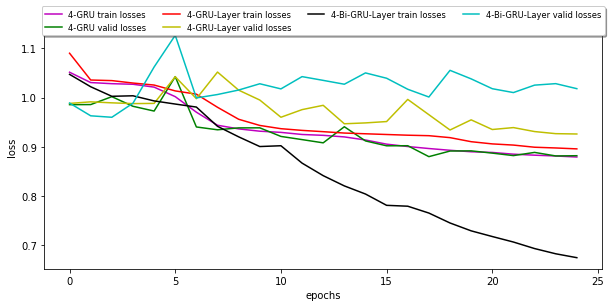

In [25]:

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
box = ax.get_position()


ax.plot(gru_train_losses, 'm', label='4-GRU train losses')
ax.plot(gru_valid_losses, 'g', label='4-GRU valid losses')
ax.plot(gru_layer_train_losses, 'r', label='4-GRU-Layer train losses')
ax.plot(gru_layer_valid_losses, 'y', label='4-GRU-Layer valid losses')
ax.plot(bigru_layer_train_losses, 'k', label='4-Bi-GRU-Layer train losses')
ax.plot(bigru_layer_valid_losses, 'c', label='4-Bi-GRU-Layer valid losses')

plt.xlabel('epochs')
plt.ylabel('loss')

ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend above current axis
ax.legend(loc='upper center',fontsize='small', bbox_to_anchor=(0.5, 1.09),
          fancybox=True, shadow=True, ncol=4) 
# Limits for the Y axis
plt.show()